# Company Bankruptcy Prediction 
Bankruptcy data from the Taiwan Economic Journal for the years 1999–2009

# Table of Contents

- [Load the Data](#load-the-data)
- [Initial Data Exploration](#initial-data-exploration)
  - [Correlation Matrix](#correlation-matrix)
  - [Remove highly correlated features](#remove-highly-correlated-features)
  - [Resampling the Data](#resampling-the-data)
- [Standardisation](#apply-standardisation)
- [Train-Test Split](#train-test-split)
- [Principal Component Analysis](#principal-component-analysis)
- [Logistic Regression](#logistic-regression)
  - [Logistic Regression without Hyper-parameter Tuning](#logistic-regression-without-hyper-parameter-tuning)
  - [Hyper-parameter Tuning](#hyper-parameter-tuning)
  - [Evaluation Beyond Accuracy](#evaluation-beyond-accuracy)
  - [Confusion Matrix](#confusion-matrix)
  - [Accuracy, Precision, Sensitivity, and Specificity](#accuracy-precision-sensitivity-and-specificity)
  - [F1 Score](#f1-score)
  - [ROC Curve](#roc-curve)
- [Decision Tree](#decision-tree)
  - [Decision Tree without Hyper-parameter Tuning](#decision-tree-without-hyper-parameter-tuning)
  - [Hyper-parameter Tuning](#decision-tree-hyper-parameter-tuning)
  - [Evaluation](#decision-tree-confusion-matrix)
  - [Accuracy, Precision, Sensitivity, and Specificity](#decision-tree-accuracy-precision-sensitivity-and-specificity)
  - [F1 Score](#decision-tree-f1-score)
- [Neural Network](#neural-network)
  - [Simple Neural Network](#simple-neural-network)
  - [Fine-tuning](#fined-tuned-neural-network)
  - [Evaluation](#fine-tuned-network-evaluation)
  - [Confusion Matrix](#fine-tuned-neural-network-confusion-matrix)
  - [Metrics](#neural-network-accuracy-precision-sensitivity-and-specificity)
  - [F1 Score](#neural-network-f1-score)
- [Conclusion](#conclusion)

In [494]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE

## Load the data

In [495]:
df = pd.read_csv('./data.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [496]:
df.shape

(6819, 96)

## Initial data exploration

In [497]:
print('Number of duplicated', df.duplicated().sum())
print('Number of nan', df.isnull().sum().sum())

Number of duplicated 0
Number of nan 0


##### Split the data into features X and predicted value Y

In [498]:
# Split the data into features and target
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

##### Correlation Matrix

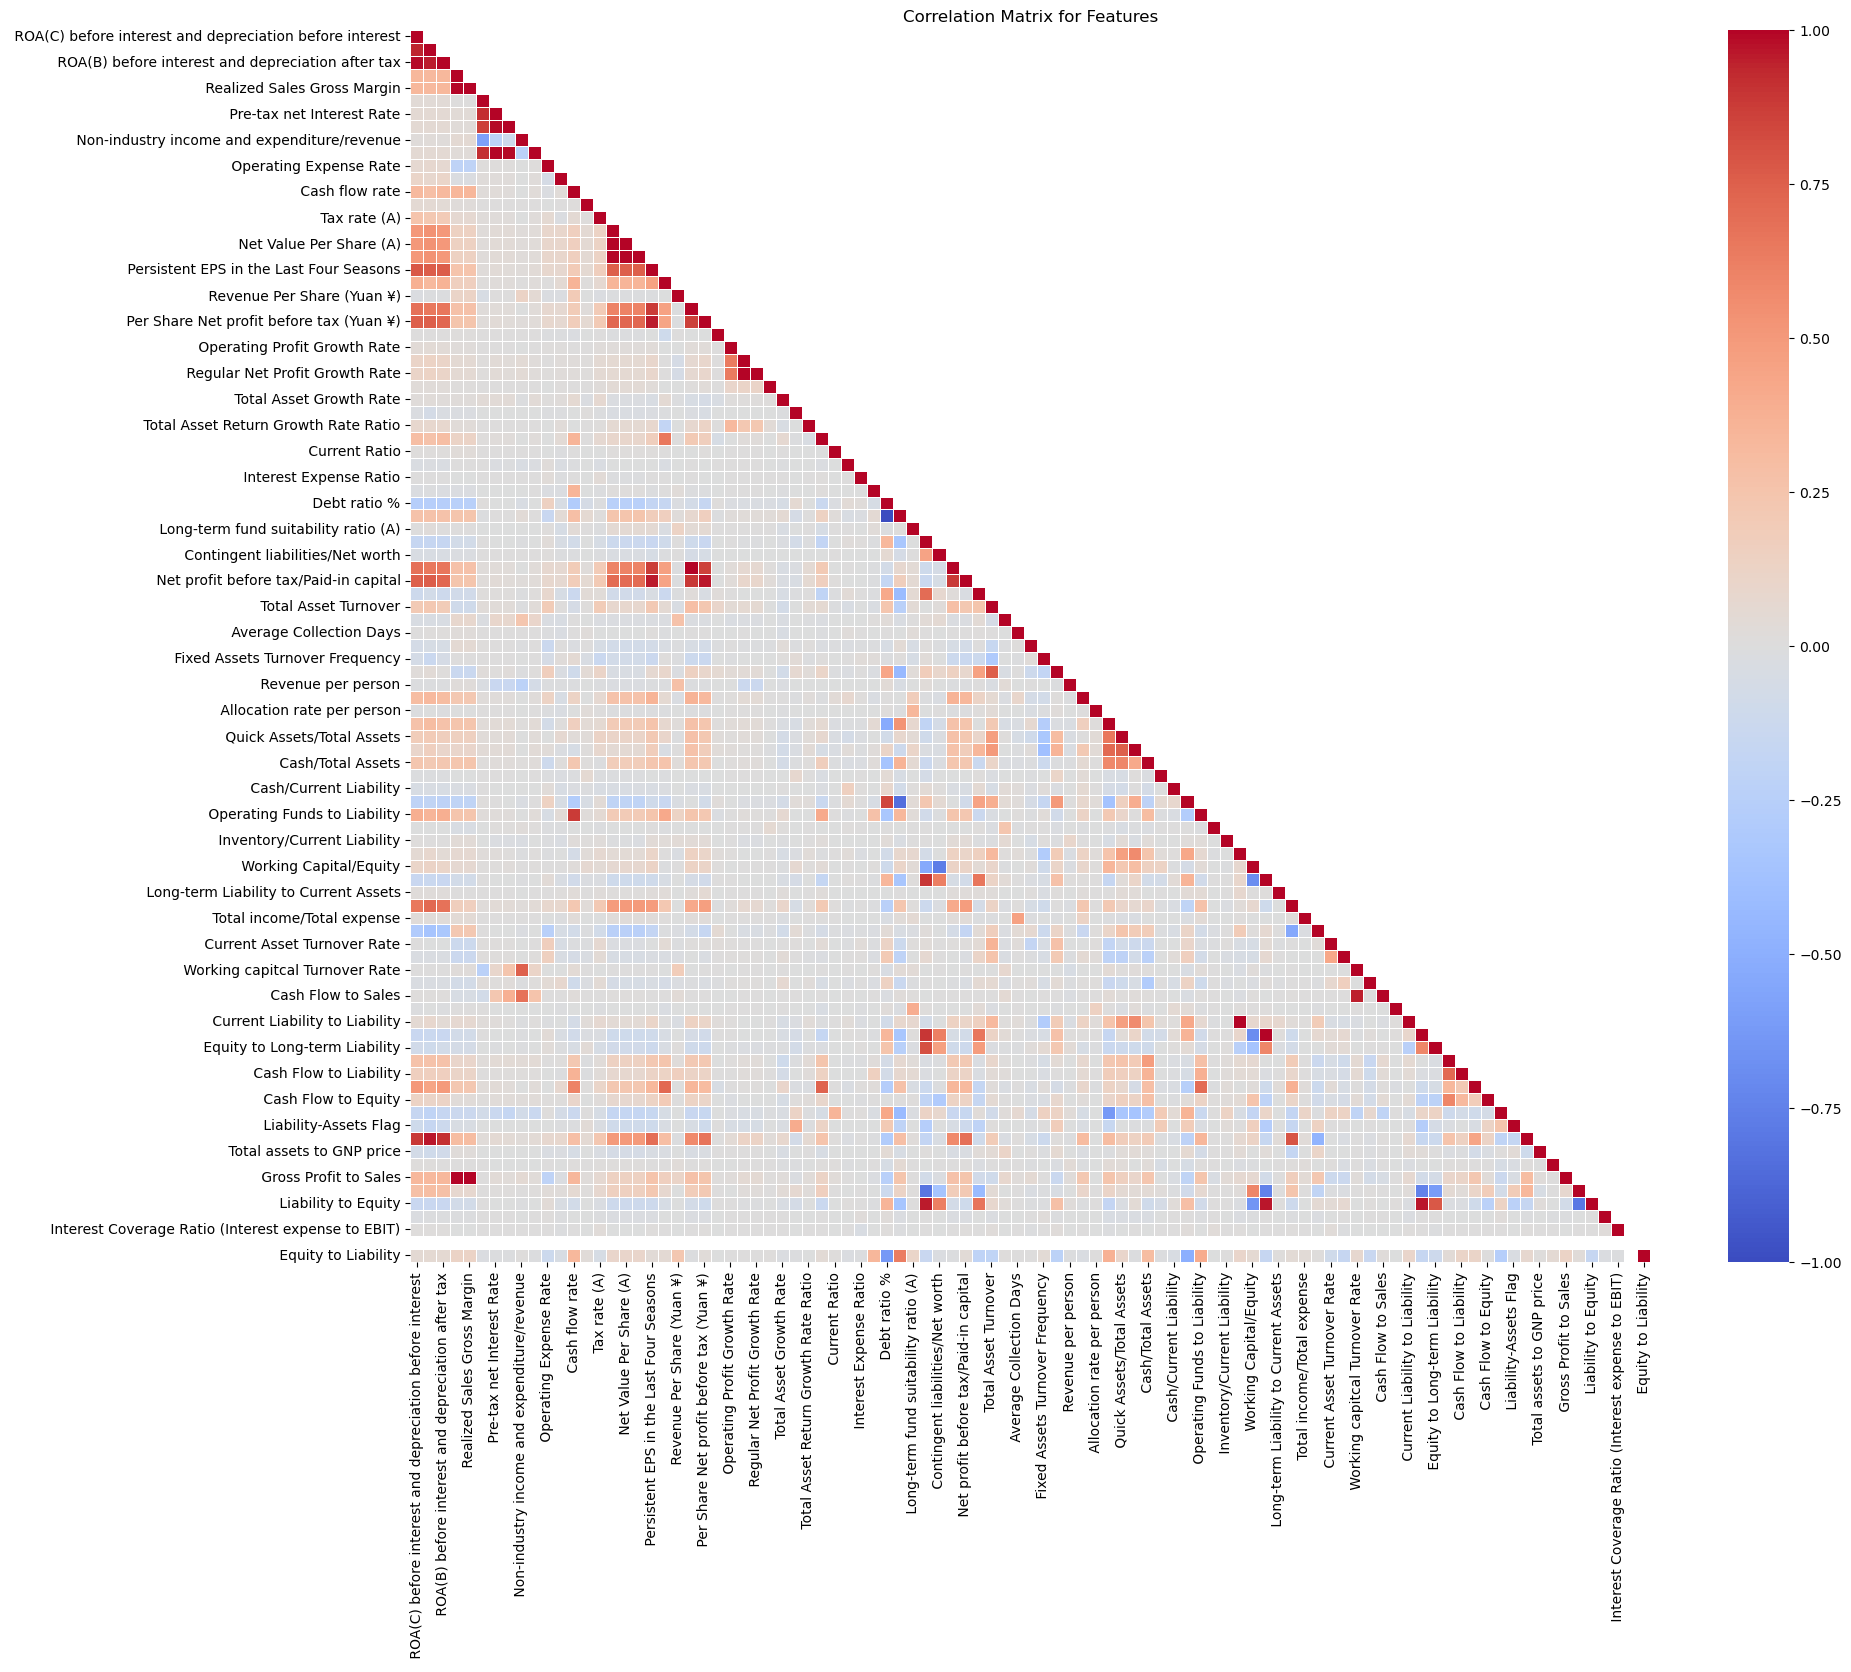

In [499]:
def display_correlation_matrix(corr_matrix):
    plt.figure(figsize=(20, 16))  # Adjust the size as needed
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5, mask=np.triu(corr_matrix, k=1))
    plt.title('Correlation Matrix for Features')
    plt.show()

corr_matrix = X.corr()
display_correlation_matrix(corr_matrix)

##### What are the features that are the most positively and negatively correlated?

In [500]:
corr_matrix = X.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Extract the upper triangle values as a series
upper_tri_series = corr_matrix.where(mask).stack()
# Exclude values of 1
upper_tri_series = upper_tri_series[upper_tri_series != 1]
print("Top 10 positive correlations:")
print(upper_tri_series.abs().sort_values(ascending=False).head(10))
print("\nTop 10 negative correlations:")
print(upper_tri_series.abs().sort_values(ascending=False).tail(10).sort_values(ascending=True))

Top 10 positive correlations:
 Debt ratio %                          Net worth/Assets                        1.000000
 Operating Gross Margin                Gross Profit to Sales                   1.000000
 Net Value Per Share (A)               Net Value Per Share (C)                 0.999837
 Operating Gross Margin                Realized Sales Gross Margin             0.999518
 Realized Sales Gross Margin           Gross Profit to Sales                   0.999518
 Net Value Per Share (B)               Net Value Per Share (A)                 0.999342
                                       Net Value Per Share (C)                 0.999179
 Operating Profit Per Share (Yuan ¥)   Operating profit/Paid-in capital        0.998696
 After-tax Net Profit Growth Rate      Regular Net Profit Growth Rate          0.996186
 Pre-tax net Interest Rate             Continuous interest rate (after tax)    0.993617
dtype: float64

Top 10 negative correlations:
 After-tax net Interest Rate               F

##### Remove highly correlated features



In [501]:
def remove_highly_correlated_features(corr_matrix, threshold=0.9):
    # Create a boolean mask for the upper triangle of the correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    return to_drop

features_to_drop = remove_highly_correlated_features(corr_matrix, threshold=0.9)

print(f"Features to drop: {features_to_drop}")

X = X.drop(features_to_drop, axis=1)

print(f"New shape of X: {X.shape}")

Features to drop: [' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Realized Sales Gross Margin', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Continuous interest rate (after tax)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Per Share Net profit before tax (Yuan ¥)', ' Regular Net Profit Growth Rate', ' Operating profit/Paid-in capital', ' Net profit before tax/Paid-in capital', ' Cash Flow to Sales', ' Current Liability to Liability', ' Current Liability to Equity', ' Net Income to Total Assets', ' Gross Profit to Sales', ' Liability to Equity']
New shape of X: (6819, 77)


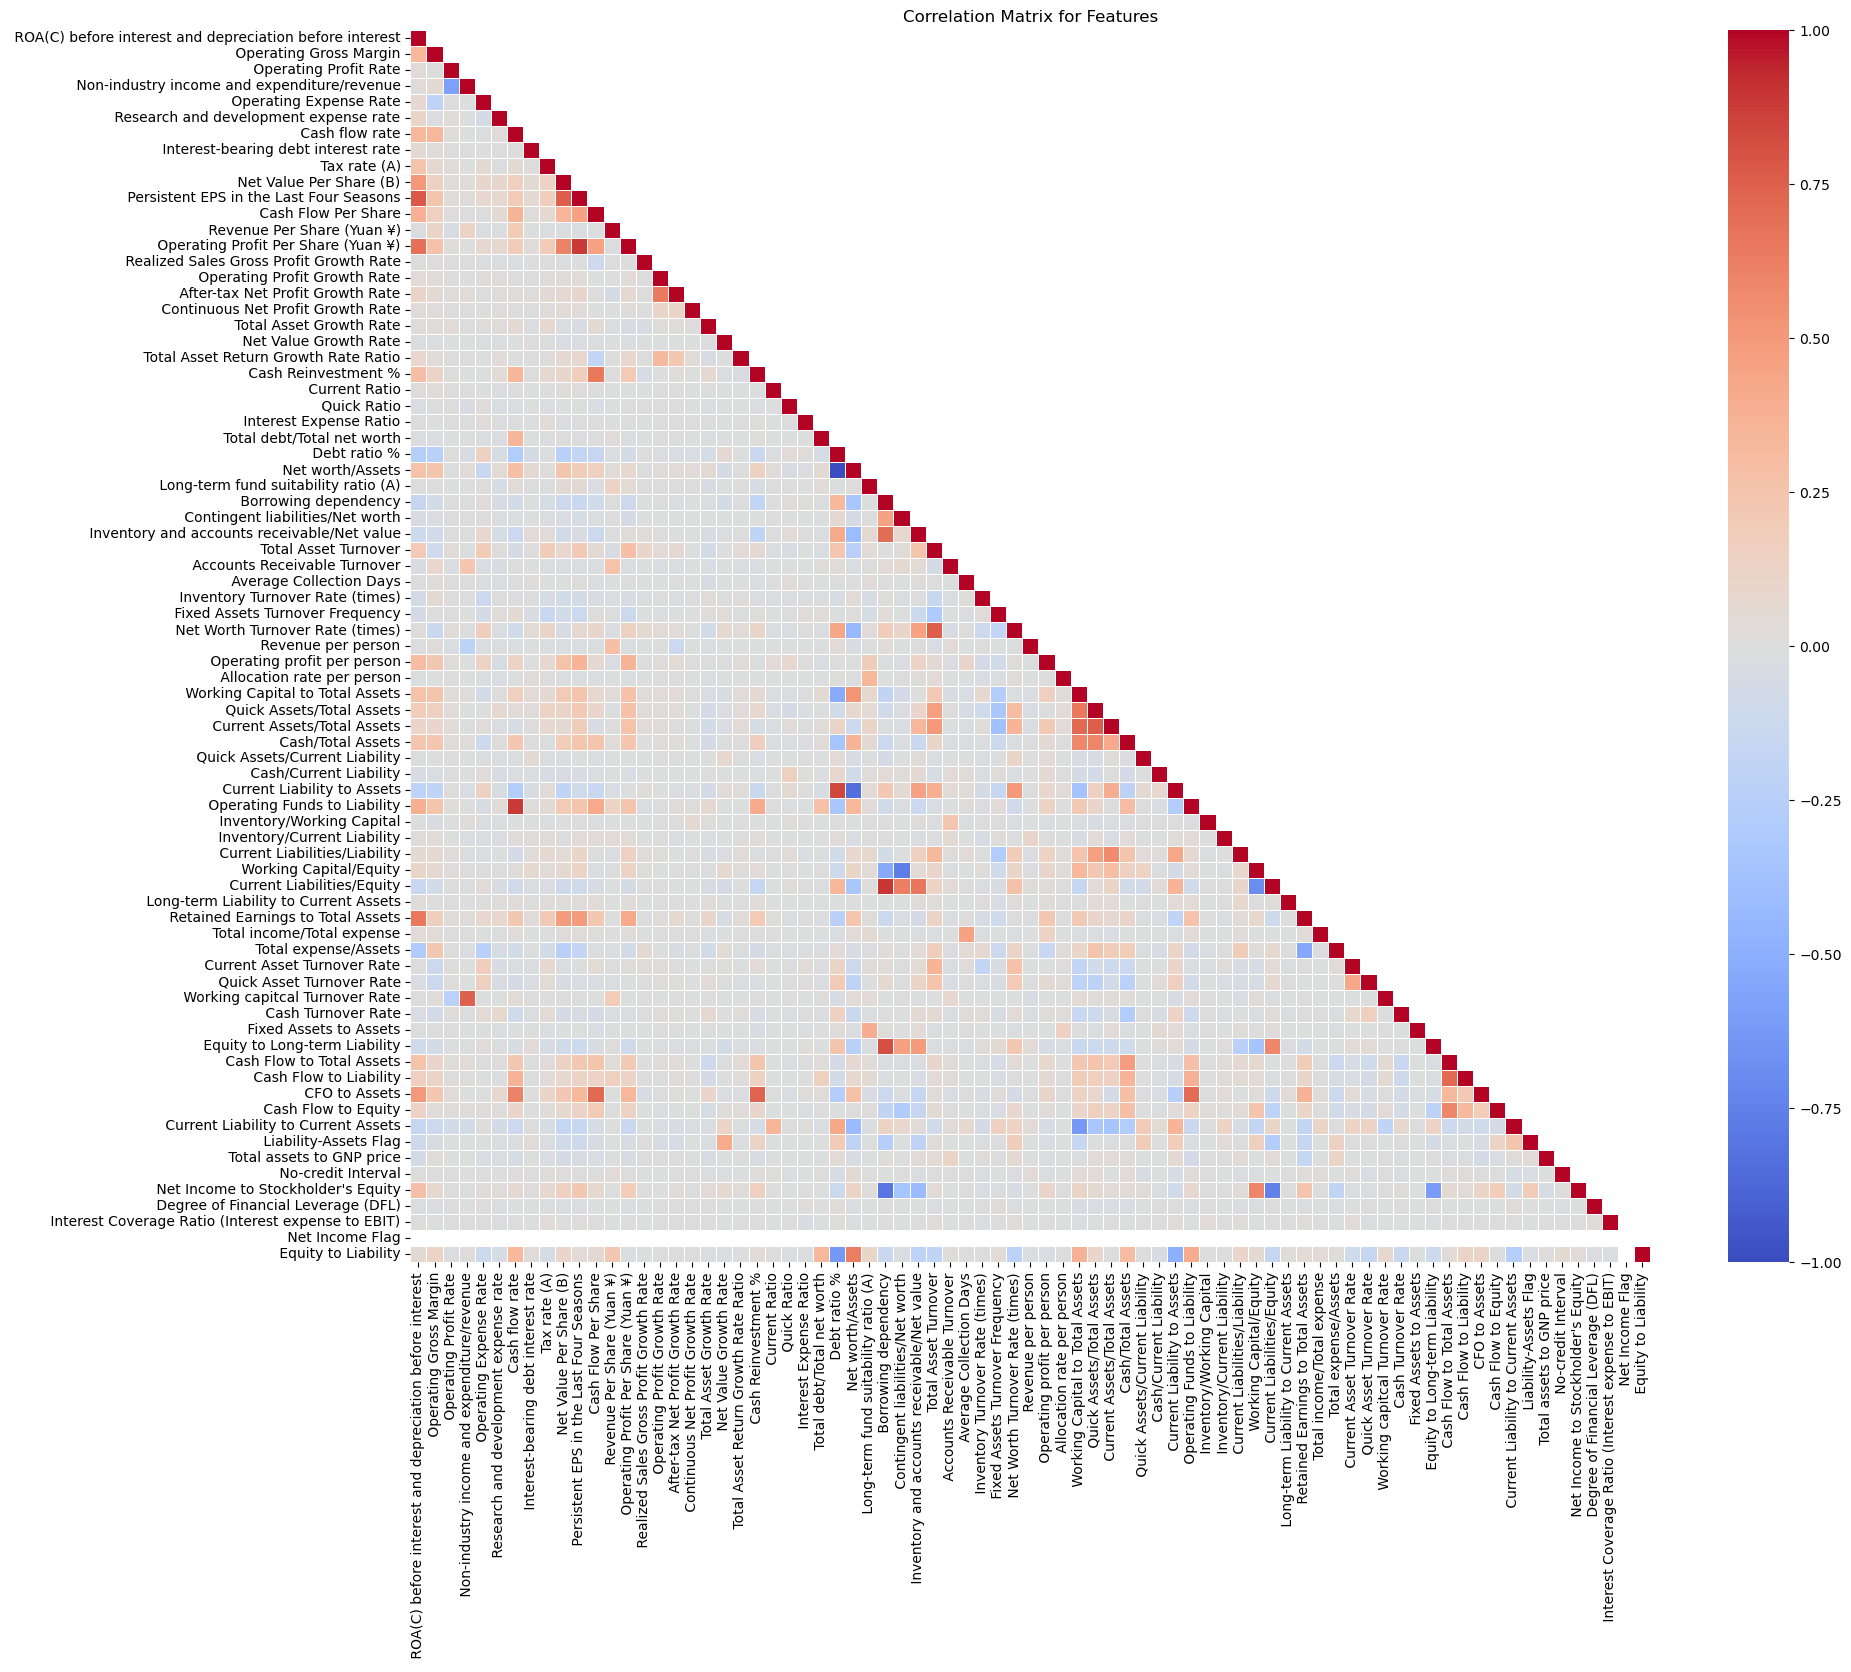

In [502]:
# Display the new correlation matrix

corr_matrix = X.corr()
display_correlation_matrix(corr_matrix)

##### Target Distribution

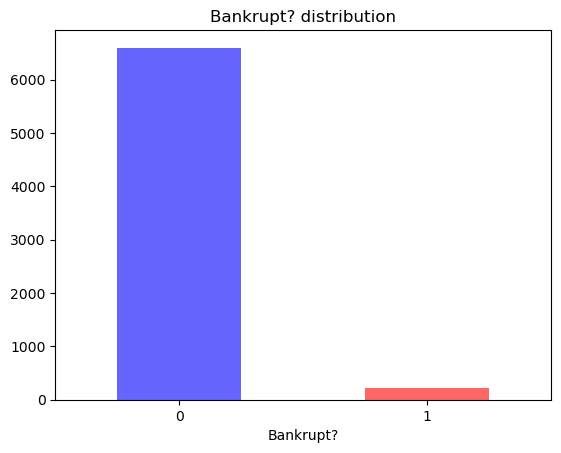

Number of bankrupt companies 220
Number of non-bankrupt companies 6599
Ratio of bankrupt companies 0.03333838460372784


In [503]:
y.value_counts().plot(kind='bar', title='Bankrupt? distribution', color=['blue', 'red'], alpha=0.6, rot=0)
plt.show()
print('Number of bankrupt companies', y.value_counts()[1])
print('Number of non-bankrupt companies', y.value_counts()[0])
print('Ratio of bankrupt companies', y.value_counts()[1] / y.value_counts()[0])

##### We can observe that the data is heavily skewed towards non-bankrupt companies.

This will lead to a bias, predicting the majority class more often, potentially ignoring the minority class. This can lead to high accuracy but poor performance on the minority class.

To address this imbalance I am going to oversample the minority class.

##### Resampling the data

Using SMOTE - Synthetic Minority Over-sampling Technique, to generate more samples from the minority class. To apply only on the training set! The validation and test set must remain untouched from the resampling. As they should reflect the real-world distribution of company bankruptcy.

In [504]:
# Apply SMOTE to the training set

print('Before oversampling', y.value_counts())
print('Ratio of bankrupt companies:', y.value_counts()[1] / y.value_counts()[0])

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# display target distribution in the SMOTE training set
print('SMOTE train set:', y_smote.value_counts())
print('Ratio of bankrupt companies:', y_smote.value_counts()[1] / y_smote.value_counts()[0])

Before oversampling Bankrupt?
0    6599
1     220
Name: count, dtype: int64
Ratio of bankrupt companies: 0.03333838460372784
SMOTE train set: Bankrupt?
1    6599
0    6599
Name: count, dtype: int64
Ratio of bankrupt companies: 1.0


##### Apply Standardisation

In [505]:
# Apply standardization to the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_smote)

##### Split the dataset into train, validation and test sets

In [506]:
# First, split the data into train+validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_smote, test_size=0.3, random_state=42)

# display the length and ratio of each set
print('Train set:', len(X_train), len(X_train) / len(X_train) + len(X_test))
print('Test set:', len(X_test), len(X_test) / len(X_train) + len(X_test))

Train set: 9238 3961.0
Test set: 3960 3960.4286642130332


##### Principal Component Analysis

Use PCA to reduce the dimensionality and potentially reduce the noise in the data.
This is experimental. Applying PCA might not yield better result.

In [507]:
# Apply PCA to the features

pca = PCA(n_components=0.90) # retain 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


number_of_components = pca.n_components_
print('Number of components:', number_of_components)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

Number of components: 43


How to choose the right number of components?
The explained variance ratio explains how much variance each principal component captures from the data.
The cumulative explained variance ratio is the accumulation of the explained variance ratio and can be used to decide how many components are needed.

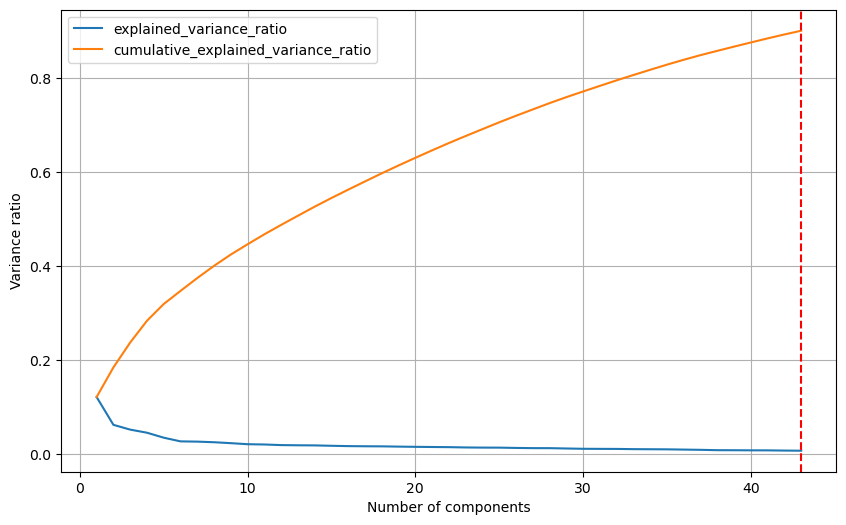

In [508]:
# Display both explained_variance_ratio and cumulative_explained_variance_ratio in a plot

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, label='explained_variance_ratio')
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio,
            label='cumulative_explained_variance_ratio')
plt.axvline(number_of_components, color='red', linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('Variance ratio')
plt.legend()
plt.grid()

## Logistic Regression

### Training

##### Logistic regression without hyper-parameter tuning

In [509]:
default_pca_lgr_classifier = LogisticRegression(random_state=42)

##### Fitting and evaluating

In [510]:
default_pca_lgr_classifier.fit(X_train_pca, y_train)

LogisticRegression(random_state=42)

In [511]:
default_lgr_PCA_test_score = default_pca_lgr_classifier.score(X_test_pca, y_test)

print('Default parameters with PCA - Test score:', default_lgr_PCA_test_score)

Default parameters with PCA - Test score: 0.8901515151515151


##### Logistic Regression: Hyper-parameter tuning

I am using Grid Search algorithm to search for the best combination of parameters. It offers an exhaustive way to find the best combination within the provided grid but it can be time-consuming as the number of combinations grows exponentially with the number of parameters and their possible values. However, the number of hyper-parameters and its possible values are relatively low for logistic regression hence the reason why I chose it.

In [512]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], # Regularization strength
    'penalty': [None, 'l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],  # Ensure the solver supports both penalties
    'tol': [1e-4, 1e-3, 1e-2],  # Add tolerance to avoid convergence warnings
}

##### Grid Search on PCA data

In [513]:
grid_search_pca_lgr_classifier = GridSearchCV(estimator=default_pca_lgr_classifier, param_grid=param_grid, n_jobs=-1)

grid_search_pca_lgr_classifier.fit(X_train_pca, y_train)

best_params_pca_lgr_classifier = grid_search_pca_lgr_classifier.best_params_

print('Best parameters pca logistic regression classifier:', best_params_pca_lgr_classifier)

/Users/pierre-henrigousse/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/pierre-henrigousse/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/pierre-henrigousse/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/pierre-henrigousse/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/pierre-henrigousse/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/pie

Best parameters pca logistic regression classifier: {'C': 1, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.0001}


In [514]:
tuned_pca_lgr_classifier = LogisticRegression(**best_params_pca_lgr_classifier, random_state=42)

tuned_pca_lgr_classifier.fit(X_train_pca, y_train)

tuned_lgr_PCA_test_score = tuned_pca_lgr_classifier.score(X_test_pca, y_test)

print('Tuned parameters with PCA - Test score:', tuned_lgr_PCA_test_score)

Tuned parameters with PCA - Test score: 0.8888888888888888


##### Comparison with and without parameter tuning on the validation set

In [515]:
# Compare the performance of the tuned model with the default model on the test set

print('Default parameters with PCA - Test score:', default_lgr_PCA_test_score)
print('Tuned parameters with PCA - Test score:', tuned_lgr_PCA_test_score)

# what is the best model?
best_model = 'tuned' if tuned_lgr_PCA_test_score > default_lgr_PCA_test_score else 'default'
print('The best model is:', best_model)

Default parameters with PCA - Test score: 0.8901515151515151
Tuned parameters with PCA - Test score: 0.8888888888888888
The best model is: default


### Evaluation beyond accuracy

So far we have only looked at the accuracy of the model. What about other evaluation metrics?

In [516]:
y_pred = tuned_pca_lgr_classifier.predict(X_test_pca)
y_pred_proba = tuned_pca_lgr_classifier.predict_proba(X_test_pca)[:, 1]

### Logistic Regression: Confusion Matrix

Validation Data Classification Report 
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      2005
           1       0.87      0.91      0.89      1955

    accuracy                           0.89      3960
   macro avg       0.89      0.89      0.89      3960
weighted avg       0.89      0.89      0.89      3960



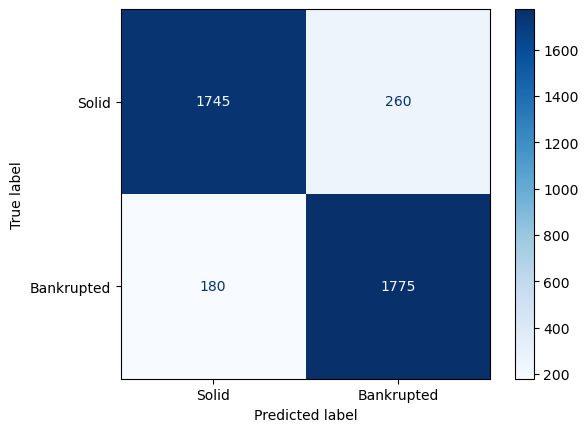

In [517]:
# confusion matrix for the tuned model without PCA
conf_matrix = confusion_matrix(y_test, y_pred)

print('Validation Data Classification Report \n', classification_report(y_test, y_pred))

class_names = { 'Solid' : 0, 'Bankrupted' : 1}

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues')
plt.show()

##### Logistic Regression: Accuracy, Precision, Sensitivity and Specificity

- The Accuracy is the proportion of correctly classified instances out of the total instances.
- The Precision is the proportion of true positive prediction among all positive predictions.
- The Sensitivity also called True Positive Rate or Recall measures the proportion of actual positives that are correctly identified by the prediction.
- The Specificity also called True Negative Rate measures the proportion of actual negatives that are correctly identified by the prediction.

In [518]:
# Sensitivity and Specificity

tn, fp, fn, tp = conf_matrix.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
lgr_precision = tp / (tp + fp)
lgr_sensitivity = tp / (tp + fn)
lgr_specificity = tn / (tn + fp)

print('True Positive:', tp, 'False Positive:', fp)
print('True Negative:', tn, 'False Negative:', fn)
print('The model made', tp + tn, 'correct predictions and', fp + fn, 'incorrect predictions.')
print('The model correctly predicted', round(accuracy * 100, 2), '% of the data points.')
print('The model correctly predicted that a company is bankrupt', round(precision * 100, 2), '% of the time.')
print('The accuracy is', accuracy)
print('The precision is', lgr_precision)
print('The sensitivity is', lgr_sensitivity)
print('The specificity is', lgr_specificity)

True Positive: 1775 False Positive: 260
True Negative: 1745 False Negative: 180
The model made 3520 correct predictions and 440 incorrect predictions.
The model correctly predicted 88.89 % of the data points.
The model correctly predicted that a company is bankrupt 94.28 % of the time.
The accuracy is 0.8888888888888888
The precision is 0.8722358722358723
The sensitivity is 0.907928388746803
The specificity is 0.8703241895261845


##### Logistic Regression: F1 Score

In [519]:
lgr_f1_score = 2 * (lgr_precision * lgr_sensitivity) / (lgr_precision + lgr_sensitivity)

print('The F1 score is', lgr_f1_score)

The F1 score is 0.8897243107769425


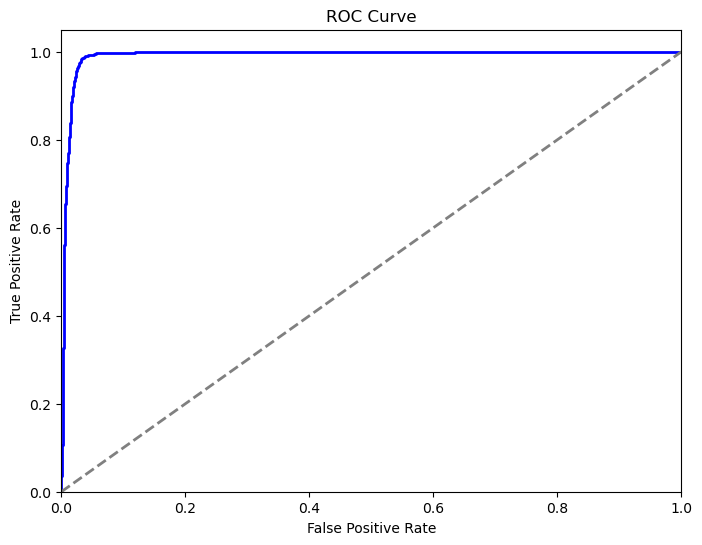

In [547]:
# Display the ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue')
# plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## Decision Tree

### Training

##### Decision Tree: without Hyper-parameter tuning

In [521]:
default_pca_dtc_classifier = DecisionTreeClassifier(random_state=42)

default_pca_dtc_classifier.fit(X_train_pca, y_train)

DecisionTreeClassifier(random_state=42)

In [522]:
# What is the accuracy of the default model on the training and validation sets?

default_dt_PCA_test_score = default_pca_dtc_classifier.score(X_test_pca, y_test)

print('Default parameters with PCA - Test score:', default_dt_PCA_test_score)

Default parameters with PCA - Test score: 0.930050505050505


##### Decision Tree: Hyper-parameter tuning

In [523]:
param_grid = {
    'criterion': ['gini', 'entropy'], # The function to measure the quality of a split
    'max_depth': [3, 5, 7, 10, None], # The maximum depth of the tree
    'min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4], # The minimum number of samples required to be at a leaf node
    'max_features': [None, 'auto', 'sqrt', 'log2'], # The number of features to consider when looking for the best split
    'max_leaf_nodes': [None, 10, 20, 30], # Grow a tree with max_leaf_nodes in best-first fashion
    'min_impurity_decrease': [0.0, 0.01, 0.1, 0.2], # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
}

randomised_search_dtc_classifier = RandomizedSearchCV(estimator=default_pca_dtc_classifier, param_distributions=param_grid, n_iter=200, n_jobs=-1)

randomised_search_dtc_classifier.fit(X_train_pca, y_train)

best_params_pca_dtc_classifier = randomised_search_dtc_classifier.best_params_

print('Best parameters non-pca decision tree classifier:', best_params_pca_dtc_classifier)

Best parameters non-pca decision tree classifier: {'min_samples_split': 10, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': None, 'criterion': 'entropy'}


In [524]:
tuned_pca_dtc_classifier = DecisionTreeClassifier(**best_params_pca_dtc_classifier, random_state=42)

tuned_pca_dtc_classifier.fit(X_train_pca, y_train)

tuned_dt_PCA_train_score = tuned_pca_dtc_classifier.score(X_train_pca, y_train)
tuned_dt_PCA_test_score = tuned_pca_dtc_classifier.score(X_test_pca, y_test)

print('Tuned parameters PCA - Train score:', tuned_dt_PCA_train_score)
print('Tuned parameters PCA - Test score:', tuned_dt_PCA_test_score)

Tuned parameters PCA - Train score: 0.9833297250487119
Tuned parameters PCA - Test score: 0.921969696969697


##### Comparison with and without parameter tuning on the test set

In [525]:
# Compare the performance of the tuned model with the default model on the test set

print('Default parameters PCA - Test score:', default_dt_PCA_test_score)
print('Tuned parameters PCA - Test score:', tuned_dt_PCA_test_score)

# what is the best model?
best_model = 'tuned' if tuned_dt_PCA_test_score > default_dt_PCA_test_score else 'default'
print('The best model is:', best_model)

Default parameters PCA - Test score: 0.930050505050505
Tuned parameters PCA - Test score: 0.921969696969697
The best model is: default


## Decision Tree: Evaluation

In [526]:
y_pred = default_pca_dtc_classifier.predict(X_test_pca)
y_pred_proba = default_pca_dtc_classifier.predict_proba(X_test_pca)[:, 1]

##### Decision Tree: Confusion Matrix

Validation Data Classification Report 
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      2005
           1       0.91      0.95      0.93      1955

    accuracy                           0.93      3960
   macro avg       0.93      0.93      0.93      3960
weighted avg       0.93      0.93      0.93      3960



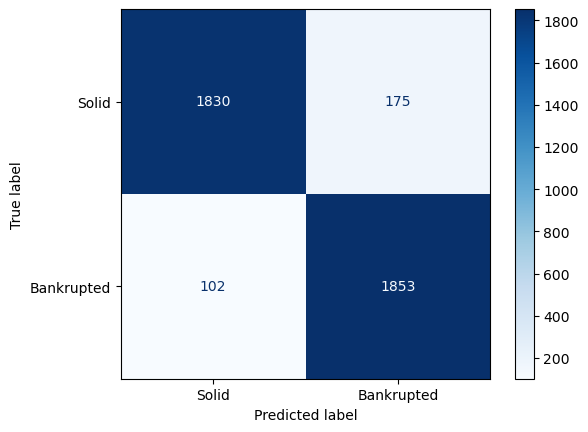

In [527]:
# confusion matrix for the default model

conf_matrix = confusion_matrix(y_test, y_pred)

print('Validation Data Classification Report \n', classification_report(y_test, y_pred))

class_names = { 'Solid' : 0, 'Bankrupted' : 1}

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues')
plt.show()

##### Decision Tree: Accuracy, Precision, Sensitivity and Specificity

In [528]:
tn, fp, fn, tp = conf_matrix.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
dt_precision = tp / (tp + fp)
dt_sensitivity = tp / (tp + fn)
dt_specificity = tn / (tn + fp)

print('True Positive:', tp, 'False Positive:', fp)
print('True Negative:', tn, 'False Negative:', fn)
print('The model made', tp + tn, 'correct predictions and', fp + fn, 'incorrect predictions.')
print('The model correctly predicted', round(accuracy * 100, 2), '% of the data points.')
print('The model correctly predicted that a company is bankrupt', round(precision * 100, 2), '% of the time.')
print('The accuracy is', accuracy)
print('The precision is', dt_precision)
print('The sensitivity is', dt_sensitivity)
print('The specificity is', dt_specificity)

True Positive: 1853 False Positive: 175
True Negative: 1830 False Negative: 102
The model made 3683 correct predictions and 277 incorrect predictions.
The model correctly predicted 93.01 % of the data points.
The model correctly predicted that a company is bankrupt 94.28 % of the time.
The accuracy is 0.930050505050505
The precision is 0.9137080867850098
The sensitivity is 0.9478260869565217
The specificity is 0.912718204488778


##### Decision Tree: F1 Score

In [529]:
dt_f1_score = 2 * (dt_precision * dt_sensitivity) / (dt_precision + dt_sensitivity)

print('The F1 score is', dt_f1_score)

The F1 score is 0.930454431333166


## Neural Network

##### Simple Neural Network

In [530]:
# define the parameters for MLPClassifier

simple_parameters = {
    'hidden_layer_sizes': (10, 10, 10),
    'activation': 'tanh',
    'learning_rate_init': 0.01,
    'max_iter': 1000,
}

In [531]:
simple_nn_classifier = MLPClassifier(**simple_parameters, random_state=42)

simple_nn_classifier.fit(X_train_pca, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(10, 10, 10),
              learning_rate_init=0.01, max_iter=1000, random_state=42)

In [532]:
simple_nn_test_score = simple_nn_classifier.score(X_test_pca, y_test)

print('Simple Neural Network Test Score:', simple_nn_test_score)

Simple Neural Network Test Score: 0.9638888888888889


##### Fined-tuned Neural Network

In [533]:
# fine tune the parameters for MLPClassifier

param_grid = {
    'hidden_layer_sizes': [(10, 10, 10), (50, 50, 50), (100, 100, 100)],
    'activation': ['tanh', 'relu'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [500, 1000, 1500],
    'alpha': [0.0001, 0.001, 0.01], # L2 penalty (regularization term) parameter
    'solver': ['lbfgs', 'adam', 'sgd'], # The solver for weight optimization
}

Note on the solvers:

The solvers refer to the optimisation algorithm used to minimise the loss function during training.

- ‘lbfgs’: An optimiser in the family of quasi-Newton methods. It is suitable for small datasets and generally converges faster and performs better for some problems.
- ‘sgd’: Stochastic Gradient Descent. It performs updates to the weights based on individual samples and can handle large datasets. It may require careful tuning of the learning rate and other hyperparameters.
- ‘adam’: An optimisation algorithm that combines the advantages of two other extensions of stochastic gradient descent. It is generally robust and well-suited for most problems without much hyperparameter tuning.

In [534]:
randomised_search_nn_classifier = RandomizedSearchCV(estimator=simple_nn_classifier, param_distributions=param_grid, n_iter=20, n_jobs=-1)

randomised_search_nn_classifier.fit(X_train_pca, y_train)

best_params_nn_classifier = randomised_search_nn_classifier.best_params_

print('Best parameters neural network classifier:', best_params_nn_classifier)

/Users/pierre-henrigousse/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/pierre-henrigousse/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/pierre-henrigousse/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWa

Best parameters neural network classifier: {'solver': 'adam', 'max_iter': 500, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.01, 'activation': 'tanh'}


In [535]:
tuned_nn_classifier = MLPClassifier(**best_params_nn_classifier, random_state=42)

tuned_nn_classifier.fit(X_train_pca, y_train)

tuned_nn_test_score = tuned_nn_classifier.score(X_test_pca, y_test)

print('Tuned Neural Network Test Score:', tuned_nn_test_score)

Tuned Neural Network Test Score: 0.9757575757575757


##### Neural Network: With or without parameter tuning?

In [536]:
# compare the performance of the tuned model with the default model on the test set

print('Simple Neural Network Test Score:', simple_nn_test_score)
print('Tuned Neural Network Test Score:', tuned_nn_test_score)

# what is the best model?
best_model = 'tuned' if tuned_nn_test_score > simple_nn_test_score else 'simple'
print('The best model is:', best_model)

Simple Neural Network Test Score: 0.9638888888888889
Tuned Neural Network Test Score: 0.9757575757575757
The best model is: tuned


### Fine-tuned Network Evaluation 

In [537]:
y_pred = tuned_nn_classifier.predict(X_test_pca)
y_pred_proba = tuned_nn_classifier.predict_proba(X_test_pca)[:, 1]

##### Fine-tuned Neural Network: Confusion Matrix

Validation Data Classification Report 
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      2005
           1       0.96      0.99      0.98      1955

    accuracy                           0.98      3960
   macro avg       0.98      0.98      0.98      3960
weighted avg       0.98      0.98      0.98      3960



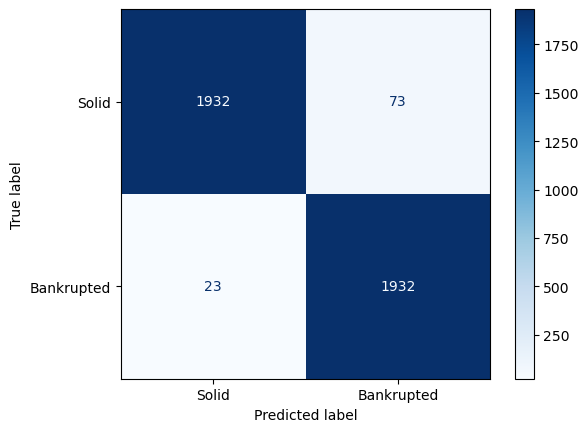

In [538]:
# confusion matrix for the default model

conf_matrix = confusion_matrix(y_test, y_pred)

print('Validation Data Classification Report \n', classification_report(y_test, y_pred))

class_names = { 'Solid' : 0, 'Bankrupted' : 1}

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues')
plt.show()

##### Neural Network: Accuracy, Precision, Sensitivity and Specificity

In [539]:
# Sensitivity and Specificity

tn, fp, fn, tp = conf_matrix.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
nn_precision = tp / (tp + fp)
nn_sensitivity = tp / (tp + fn)
nn_specificity = tn / (tn + fp)

print('True Positive:', tp, 'False Positive:', fp)
print('True Negative:', tn, 'False Negative:', fn)
print('The model made', tp + tn, 'correct predictions and', fp + fn, 'incorrect predictions.')
print('The model correctly predicted', round(accuracy * 100, 2), '% of the data points.')
print('The model correctly predicted that a company is bankrupt', round(precision * 100, 2), '% of the time.')
print('The accuracy is', accuracy)
print('The precision is', nn_precision)
print('The sensitivity is', nn_sensitivity)
print('The specificity is', nn_specificity)

True Positive: 1932 False Positive: 73
True Negative: 1932 False Negative: 23
The model made 3864 correct predictions and 96 incorrect predictions.
The model correctly predicted 97.58 % of the data points.
The model correctly predicted that a company is bankrupt 94.28 % of the time.
The accuracy is 0.9757575757575757
The precision is 0.9635910224438903
The sensitivity is 0.9882352941176471
The specificity is 0.9635910224438903


##### Neural Network: F1 Score

In [540]:
nn_f1_score = 2 * (nn_precision * nn_sensitivity) / (nn_precision + nn_sensitivity)

print('The F1 score is', nn_f1_score)

The F1 score is 0.9757575757575757


##### Neural Network: ROC curve

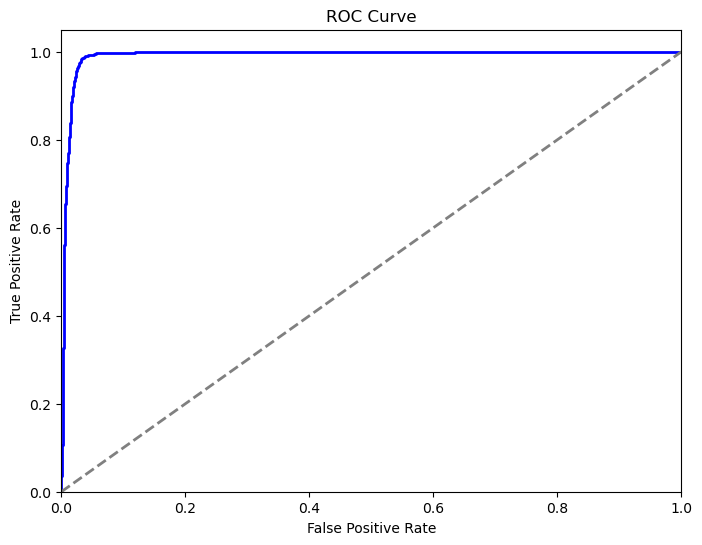

In [549]:
# Display the ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue')
# plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## Conclusion

Which Model is the best at determining whether a company is bankrupt or not.

##### comparing the accuracy of all the three Models

The accuracy is a nice to have metric but as we have seen the class distribution is unbalanced and the model might always predicts the majority class wrongly bumping up the accuracy but it does perform poorly on the minority class.

In [541]:
# comparing the accuracy of all the three models

print('Logistic Regression Classifier Test Score:', tuned_lgr_PCA_test_score)
print('Decision Tree Classifier Test Score:', tuned_dt_PCA_test_score)
print('Neural Network Classifier Test Score:', tuned_nn_test_score)

Logistic Regression Classifier Test Score: 0.8888888888888888
Decision Tree Classifier Test Score: 0.921969696969697
Neural Network Classifier Test Score: 0.9757575757575757


##### Comparing the Precision of all three Models

It is the ratio of true positive predictions to the total number of positive predictions.
It appears to be a better metric than accuracy for two reasons:
- Depending on the situation the cost of false positives could be hight. (A predicted non bankrupt which is actually bankrupt)
- If the model makes a significant number of false positive predictions, the accuracy will be high but the precision will be poor. So, we can't rely on accuracy only.

In [542]:
# comparing the precision of all the three models

print('Logistic Regression Classifier Precision:', lgr_precision)
print('Decision Tree Classifier Precision:', dt_precision)
print('Neural Network Classifier Precision:', nn_precision)

Logistic Regression Classifier Precision: 0.8722358722358723
Decision Tree Classifier Precision: 0.9137080867850098
Neural Network Classifier Precision: 0.9635910224438903


##### Comparing the F1-score of all three Models

It is the harmonic mean of precision and recall, providing a single metric that balances both the precision and recall of the model.

This metric is particularly useful as I think both false positives and false negative are important to consider.

In [543]:
# comparing the F1-score of all the three models

print('Logistic Regression Classifier F1 Score:', lgr_f1_score)
print('Decision Tree Classifier F1 Score:', dt_f1_score)
print('Neural Network Classifier F1 Score:', nn_f1_score)

Logistic Regression Classifier F1 Score: 0.8897243107769425
Decision Tree Classifier F1 Score: 0.930454431333166
Neural Network Classifier F1 Score: 0.9757575757575757


In [544]:
# which one is the best model based on the precision and f1-score?

best_model = 'Logistic Regression' if lgr_precision > dt_precision and lgr_precision > nn_precision else 'Decision Tree' if dt_precision > lgr_precision and dt_precision > nn_precision else 'Neural Network'

print('The best model based on precision is:', best_model)

best_model = 'Logistic Regression' if lgr_f1_score > dt_f1_score and lgr_f1_score > nn_f1_score else 'Decision Tree' if dt_f1_score > lgr_f1_score and dt_f1_score > nn_f1_score else 'Neural Network'

print('The best model based on F1-score is:', best_model)


The best model based on precision is: Neural Network
The best model based on F1-score is: Neural Network


The Model that perform the best is: Neural Network with parameter tuned